![title](sport_watch_logos.png)


# Introduction | Use CNN to Classify Physical Activities 

We are going to train a Convolutional Neural Network (CNN) using [**Keras**](https://keras.io/) to predict which physical activity a user is engaged base on biometric data collected from a wrist wearable. 

Using a CNN may seam like a non-intutative approach to solving this problem considering that CNNs are specifically designed to classify images -- not time series data. The reserchers of the following article address that concern, while also demonstrating the success of using this appraoch -- reaching a test accuracy of over 90%. 

In the paper, Terry, Vahid, and Dana leaverage the fact that deep learning networks engineer whatever features they need in order to improve their predictive performance. The challenge for the data scientist is no longer feature engineering, but feature formating. The authors show that depending how one formats the time series data into a matrix it will directly affect how the CNN convolves the features and that directly affects performance. 

In this notebook, we're going to implement their most successful appraoch on the [**Daily Sports and Activities**](http://archive.ics.uci.edu/ml/datasets/Daily+and+Sports+Activities) data set from the [**UCI Machine Learning Repository**](http://archive.ics.uci.edu/ml/index.html).

In [14]:
from IPython.display import HTML
HTML('<iframe src=https://arxiv.org/pdf/1610.07031.pdf width=1000 height=1400></iframe>')

-----

# About the Data

8 users all participate in the same 19 activites. Each of the 5 devices (4 limbs and 1 torso) have 9 sensors (x,y,z accelerometers, x,y,z gyroscopes, and x,y,z magnetometers). The data is collected in 5 second segments with a frequency of 25 Hz for a total of 5 minutes for each activity for each user. 

### The 19 activities are: 

    sitting (A1), 
    standing (A2), 
    lying on back and on right side (A3 and A4), 
    ascending and descending stairs (A5 and A6), 
    standing in an elevator still (A7) 
    and moving around in an elevator (A8), 
    walking in a parking lot (A9), 
    walking on a treadmill with a speed of 4 km/h (in flat and 15 deg inclined positions) (A1 
    0 and A11), 
    running on a treadmill with a speed of 8 km/h (A12), 
    exercising on a stepper (A13), 
    exercising on a cross trainer (A14), 
    cycling on an exercise bike in horizontal and vertical positions (A15 and A16), 
    rowing (A17), 
    jumping (A18), 
    and playing basketball (A19). 
    
### File structure: 

    19 activities (a) (in the order given above) 
    8 users (p) 
    60 segments (s) 
    5 units on torso (T), right arm (RA), left arm (LA), right leg (RL), left leg (LL) 
    9 sensors on each unit (x,y,z accelerometers, x,y,z gyroscopes, x,y,z magnetometers) 

Since commerically available IoT wearables are a single device (i.e. a wrist watch), we will only use the right arm portion of this data and ignore the data collected from the other devices strapped on the users. 

----

# Formating the Data

In [29]:
# import packages 
import numpy as np
import pandas as pd
import os
from time import time
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
import pickle

import keras
from keras.regularizers import l1, l2
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from matplotlib import animation, rc
from IPython.display import HTML, Image
%matplotlib inline

In [12]:
# these functions are used to load the data from the hierarchy of folders in which it is stored

def generate_feature_names():
    '''Creates feature names for dataframe header'''
    feat_names = []
    for unit_label in ["T", "RA", "LA", "RL", "LL"]:
        for sensor  in ["acc","gyro","mag"]:
            for position in ['X','Y','Z']:
                feat_names.append(unit_label + "_" + position + sensor)
    return feat_names

def get_activity_files_names():
    '''Creates activity file names'''
    activity_files = []
    for num in np.arange(1,20,1):
        if num < 10:
            activity_files.append("a0{}".format(num))
        else:
            activity_files.append("a{}".format(num))
    return activity_files

def get_segment_files_names():
    '''Creates segment file names'''
    segment_files = []
    for num in np.arange(1,61,1):
        if num < 10:
            segment_files.append("s0{}.txt".format(num))
        else:
            segment_files.append("s{}.txt".format(num))
    return segment_files

def get_data(data_home, feat_names, body_part, activity_files, person_files, segment_files):
    '''loads data, extracts features, and transforms data'''
    player_data = defaultdict(list)
    act_index = 0
    # for activity_i
    for act_i, activity in enumerate(activity_files):
        act_index += 1
        # for person_j
        for per_i, person in enumerate(person_files):
            # for segment_k
            for seg_i, segment in enumerate(segment_files): 
                
                # load segment data
                segment_path = data_home + activity + "/" + person + "/" + segment
                
                # put data in dataframe
                df = pd.read_csv(segment_path, header=None)
                
                # assign column names
                df.columns = feat_names
                df = df[body_part].copy()
                
                # each segment is now a row 
                player_data[act_index].append(df)   
                
    return player_data

In [13]:
# generate names of activities and segments to create file names
activity_files = get_activity_files_names()
segment_files =  get_segment_files_names()
person_files = ["p{}".format(num) for num in np.arange(1,9,1)]

In [14]:
data_home = "/Users/Alexander/IPython_Notebooks/CNN_Activity_Classification/data/"
feat_names = generate_feature_names()
right_arm = feat_names[9:18]

In [15]:
# extract revelent data
start = time()
player_data = get_data(data_home,
                       feat_names, 
                       right_arm, 
                       activity_files, 
                       person_files, 
                       segment_files)
end = time()
print (end - start)

58.39300894737244


In [17]:
player_data_file = "player_data.pkl"
pickle.dump(player_data, open(player_data_file, 'wb'))

In [85]:
player_data_file = "player_data.pkl"
player_data = pickle.load(open(player_data_file, 'rb'))

We’ve extracted the right arm data from the nested folders and stored it in a dictionary where the keys are the activity ids and the 5 second segments of data are the samples. We don’t distinguish samples between players since the goal is to train a model to learn the signatures  of rowing or walking and not to learn WHO is doing the rowing or walking.

In [86]:
# keys in the dict are the activity numbers
player_data.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [87]:
# this many 2D samples for each activity 
len(player_data[1])

480

Each segment of data is 5 seconds and long recorded at 25 Hz, so each segment has 125 rows. Since we're only interested in the measurements one of the five devices (the right arm sensor) that drops the number of features from 45 to 9. 
   
    25 Hz --> 25 samples per second 
    5 second samples
    25 * 5 = 125 samples (rows)
    9 features --> 3 dims for each of the 3 devices

In [88]:
# fortunately for us, we won't have to zero-pad our samples like the authors did
# due to the way that the data was measured 

# the dims of single segment of data
player_data[1][1].shape

(125, 9)

In [89]:
# the right arm readings of each activity (a single segment of data)
player_data[1][1].head()

,RA_Xacc,RA_Yacc,RA_Zacc,RA_Xgyro,RA_Ygyro,RA_Zgyro,RA_Xmag,RA_Ymag,RA_Zmag
0,0.62906,5.7852,7.8624,0.023668,0.003574,-0.008247,-0.56515,-0.56762,-0.20656
1,0.59229,5.8239,7.8745,0.027182,0.000057,-0.004739,-0.56430,-0.56565,-0.20720
2,0.60946,5.8190,7.8795,0.002920,-0.003381,0.002559,-0.56486,-0.56409,-0.20765
3,0.61184,5.8095,7.8551,-0.004387,-0.019235,0.006979,-0.53649,-0.55611,-0.18054
4,0.65361,5.7851,7.8796,0.009090,-0.010397,0.008698,-0.56850,-0.56411,-0.20785


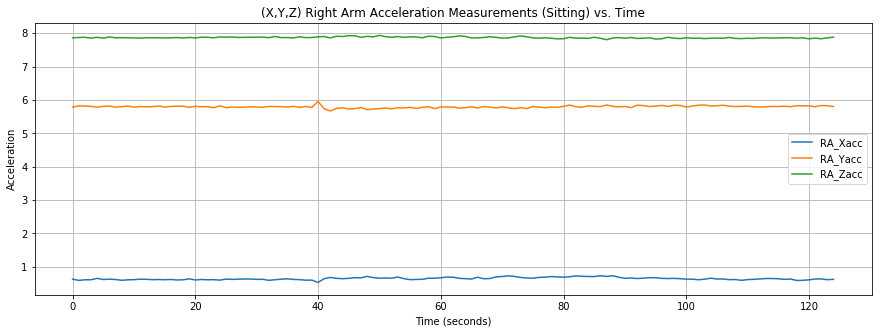

In [90]:
ax = \
player_data[1][1][["RA_Xacc", "RA_Yacc", "RA_Zacc"]].plot(\
    title = "(X,Y,Z) Right Arm Acceleration Measurements (Sitting) vs. Time",
    figsize=(15,5));

ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Acceleration");
plt.grid()
plt.savefig("./images/RA_Sitting_ACC.png")

Above we see the right arm acceleration readings for the activity of sitting. We can see that there is no variation in the acceleration (which is to be expected). UCI doesn't make it clear what the physical units are for acceleration here; the standard unit is meters per second squared but it seem highly unlikely that someone who is sitting is accelerating at 8 $\frac{m}{s^2}$. It seems that the values on the plot for each dimension are resting values, but one can't be too sure. 

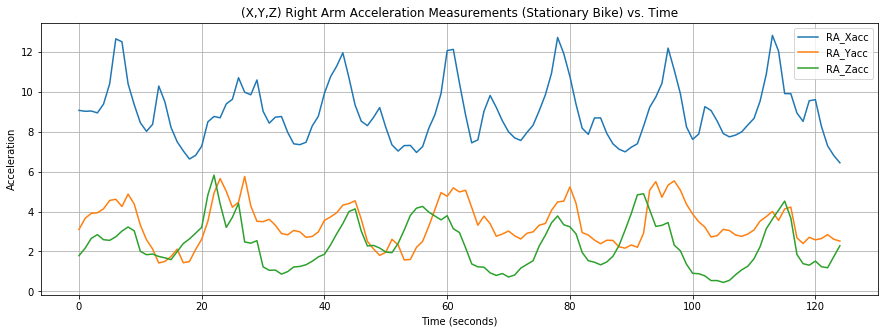

In [24]:
ax = \
player_data[9][1][["RA_Xacc", "RA_Yacc", "RA_Zacc"]].plot(\
    title = "(X,Y,Z) Right Arm Acceleration Measurements (Stationary Bike) vs. Time",
    figsize=(15,5));

ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Acceleration");
plt.grid()
plt.savefig("./images/RA_bike_ACC.png")

The above plot shows the readings for someone that is running on a treadmill. We can see that there are regular oscillations. Note that the X dimensions for this data represents the vertical dimensions, which makes sense. As someone runs on a treadmill, typically the arms swing up and down within a bounded range and do so with a somewhat regular periodicity. The Y and Z dimensions represent the plane that is parallel to the ground (i.e. left/right and forward/backward). There is less acceleration in these dimensions, which is also expected, arms usually don’t swing very much from side-to-side.

You read more about how these devices work in this [**paper**](http://yoksis.bilkent.edu.tr/pdf/files/8333.pdf).

-----

## Intuition Behind Data Formating

The paper states that the way to format the data for acheiving the best performance is to isolate each sensor from each other by dedicating an entire channel to each sensor. This way there is no inter-sensor convolutions. The intuition here is that convolving unrelated features like X dimension acceleration with Z dimension magnetometer data is not physically meaningful and will lead to poorer performance by the CNN. 

My formal training in Physics leads me to accept the intution of the authors. Not only because the author's experimental results support their intution but also because of the Physics and mathematics at play here. 

Mathematically, convolutions can be thought of as integrations over two functions to create a thrid function, where that resulting function is a blend of the first two. 

$${\displaystyle {\begin{aligned}(f*g)(t)&\,{\stackrel {\mathrm {def} }{=}}\ \int _{-\infty }^{\infty }f(\tau )g(t-\tau )\,d\tau \\&=\int _{-\infty }^{\infty }f(t-\tau )g(\tau )\,d\tau .\end{aligned}}}$$


One way to try to intuit this idea is to think about the beating of a drum idea shared on [**Quora**](https://www.quora.com/What-is-the-physical-significance-of-convolution). If you beat a drum at time t, then beat the same drum at time t + 1, you're going to hear the combination (the sum) of the second beat and the trailing off of the first beat. Add those two beats together and you'll get the combined sound two beats added together, but with a time shift on one beat -- that's convolution! 

This is the idea that we are trying to preserve when we isolate each sensor to its own channel. We want to convolve biometrics from within the same device in order to generate an additional feature that will be a combination of the original features from each sensor. To extend the anaology, just as convolution for drum beats generates a smooth percussion sound, we want to generate a smooth time signitures for each sensor for each activity.  


In [91]:
acc_cols = ["RA_Xacc","RA_Yacc", "RA_Zacc"]
gyro_cols = ["RA_Xgyro","RA_Ygyro", "RA_Zgyro"]
mag_cols = ["RA_Xmag","RA_Ymag", "RA_Zmag"]

# the paper says to think of each device has a RBG color channel 
R = player_data[1][1][acc_cols].values
B = player_data[1][1][gyro_cols].values
G = player_data[1][1][mag_cols].values

In [92]:
# notice how the top 2D array contains the acceleration values 
rbg_sample = np.array((R,B,G))
print(rbg_sample.shape)
# X | Y | Z 
#
#
rbg_sample

(3, 125, 3)


array([[[  6.29060000e-01,   5.78520000e+00,   7.86240000e+00],
        [  5.92290000e-01,   5.82390000e+00,   7.87450000e+00],
        [  6.09460000e-01,   5.81900000e+00,   7.87950000e+00],
        ..., 
        [  6.35990000e-01,   5.83370000e+00,   7.83620000e+00],
        [  6.14080000e-01,   5.82870000e+00,   7.86280000e+00],
        [  6.24020000e-01,   5.80440000e+00,   7.88460000e+00]],

       [[  2.36680000e-02,   3.57400000e-03,  -8.24700000e-03],
        [  2.71820000e-02,   5.70000000e-05,  -4.73900000e-03],
        [  2.92000000e-03,  -3.38100000e-03,   2.55900000e-03],
        ..., 
        [  1.64980000e-02,   9.14000000e-04,  -1.42670000e-02],
        [ -1.60700000e-03,  -5.11100000e-03,   2.74100000e-03],
        [  1.37250000e-02,   7.21400000e-03,   1.20000000e-05]],

       [[ -5.65150000e-01,  -5.67620000e-01,  -2.06560000e-01],
        [ -5.64300000e-01,  -5.65650000e-01,  -2.07200000e-01],
        [ -5.64860000e-01,  -5.64090000e-01,  -2.07650000e-01],
        

In [93]:
player_data[1][1].head()

,RA_Xacc,RA_Yacc,RA_Zacc,RA_Xgyro,RA_Ygyro,RA_Zgyro,RA_Xmag,RA_Ymag,RA_Zmag
0,0.62906,5.7852,7.8624,0.023668,0.003574,-0.008247,-0.56515,-0.56762,-0.20656
1,0.59229,5.8239,7.8745,0.027182,0.000057,-0.004739,-0.56430,-0.56565,-0.20720
2,0.60946,5.8190,7.8795,0.002920,-0.003381,0.002559,-0.56486,-0.56409,-0.20765
3,0.61184,5.8095,7.8551,-0.004387,-0.019235,0.006979,-0.53649,-0.55611,-0.18054
4,0.65361,5.7851,7.8796,0.009090,-0.010397,0.008698,-0.56850,-0.56411,-0.20785


In [102]:
for activty, data_list in player_data.items():
    print (len(data_list[0]))
    break

125


In [103]:
def reformate_data(player_data, acc_cols, gyro_cols, mag_cols):
    '''Reformats the dims of the data'''
    X_data = []
    Y_data = []
    for activty, data_list in player_data.items():
        for df in data_list:
            
            acc = df[acc_cols].values
            gyro = df[gyro_cols].values
            mag = df[mag_cols].values

            formated_sample = np.array((acc,gyro,mag))

            X_data.append(formated_sample)
            Y_data.append(activty)

    return np.array(X_data), np.array(Y_data)

In [133]:
start = time()
X_data, Y_data = reformate_data(player_data, 
                                acc_cols, 
                                gyro_cols, 
                                mag_cols)
end = time()
print (end - start)

16.255823135375977


In [134]:
Y_data.shape

(9120,)

In [135]:
# (samples, channels, rows, cols)
X_data.shape

(9120, 3, 125, 3)

In [136]:
Y_data = Y_data.reshape((Y_data.shape[0],1))

In [139]:
Y_data.shape

(9120, 1)

In [140]:
np.unique(Y_data)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])

In [110]:
# labels must be one-hot encoded for the softmax layer of the CNN
encoder = OneHotEncoder()
encoder.fit(Y_data)  

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [111]:
Y_data = encoder.transform(Y_data).toarray()

In [112]:
Y_data

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [113]:
X_data, Y_data = shuffle(X_data, Y_data)

In [114]:
save_data = "model_ready_data.pkl"
pickle.dump((X_data, Y_data), open(save_data, 'wb'))

In [2]:
save_data = "model_ready_data.pkl"
X_data, Y_data = pickle.load(open(save_data, 'rb'))

In [3]:
num_classes = 19

In [4]:
len(Y_data[0])

19

We are going to devide the data set up into train, test, and holdout sets. The train and test sets will be used to track the model's training as it progresses through the epochs. The holdout set will be used as a final check on the model's ability to generalize. 

In [17]:
X_train, X_test, Y_train, Y_test  = train_test_split(X_data, Y_data, test_size = 0.10, random_state = 1234)

In [18]:
X_train[0]

array([[[  1.30520000e+00,   9.69060000e+00,   3.68450000e-01],
        [  1.31490000e+00,   9.68590000e+00,   3.34470000e-01],
        [  1.30990000e+00,   9.68840000e+00,   3.10150000e-01],
        ..., 
        [  1.35860000e+00,   9.71500000e+00,   3.13260000e-01],
        [  1.37350000e+00,   9.67610000e+00,   3.27750000e-01],
        [  1.37360000e+00,   9.66630000e+00,   3.47150000e-01]],

       [[  1.97840000e-02,  -1.66080000e-02,  -7.66000000e-04],
        [  8.32800000e-03,   9.94300000e-03,   1.24800000e-03],
        [  5.43300000e-03,  -2.00970000e-02,   1.11100000e-03],
        ..., 
        [  5.61900000e-03,  -5.15900000e-03,  -1.28740000e-02],
        [  9.05900000e-03,   2.99000000e-03,   1.02580000e-02],
        [  9.88400000e-03,  -7.62800000e-03,   9.30500000e-03]],

       [[  2.03880000e-01,  -8.07320000e-01,   5.44790000e-01],
        [  2.04000000e-01,  -8.06550000e-01,   5.44780000e-01],
        [  2.03850000e-01,  -8.05450000e-01,   5.46810000e-01],
        

------


# Train CNN

Here we will build and train our CNN. We will follow the paper in selecting two convolutional layers with max pooling. But instead of using a single fully connected layer, we'll use two. 

Also, the paper used TensorFlow to build their model. TensorFlow is a great package to use for building deep learning models, however it requires a lot of boilerplate code. The beauty of Keras is that it is a wrapper around TensorFlow that takes care of that boilerplate code for you. Which allows for much quicker iterations. 

Below is a diagram of what our model looks like: there is a convolution layer followed by a maxpool layer, those two layers repeat, followed by two fully connected forwardfeeding layers, finished off with a softmax layer for classifications. The digagram has certain values listed for hyperparameters such as stride size and number of hidden nodes, **note** that the diagram is simply a reference for the CNN architecture (we will not be using those values). 

![](http://adventuresinmachinelearning.com/wp-content/uploads/2017/04/CNN-example-block-diagram-1024x340.jpg)



In [45]:
# CNN model
model = Sequential()


model.add(Conv2D(filters=32, 
                 kernel_size=(1, 1), 
                 strides=(1, 1),
                 activation='relu',
                 input_shape=(3, 125, 3)))

model.add(MaxPooling2D(pool_size=(1, 1), 
                       strides=(1, 1)))

model.add(Conv2D(filters=64, 
                 kernel_size=(2, 2), 
                 activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dropout(rate=.2))
model.add(Dense(1000, 
                activation='relu'))
                #activity_regularizer=l2(0.001)))
model.add(Dropout(rate=.2))
model.add(Dense(500, 
                activation='relu'))
                #activity_regularizer=l2(0.001)))
model.add(Dense(num_classes, activation='softmax'))

In [46]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=['accuracy'])

In [47]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.losses = []
        self.test_acc = []
        self.test_losses = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.test_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.test_acc.append(logs.get('val_acc'))

In [48]:
history = AccuracyHistory()

In [50]:
model.fit(X_train, Y_train,
          batch_size=100,
          epochs=10,
          verbose=1,
          validation_data=(X_test, Y_test),
          callbacks=[history])

Train on 8208 samples, validate on 912 samples
Epoch 1/10
8208/8208 [==============================] - 16s - loss: 1.7007 - acc: 0.4193 - val_loss: 2.0449 - val_acc: 0.3673
Epoch 2/10
8208/8208 [==============================] - 16s - loss: 1.4764 - acc: 0.4862 - val_loss: 1.7787 - val_acc: 0.4232
Epoch 3/10
8208/8208 [==============================] - 16s - loss: 1.3105 - acc: 0.5352 - val_loss: 1.3754 - val_acc: 0.4726
Epoch 4/10
8208/8208 [==============================] - 17s - loss: 1.1136 - acc: 0.6095 - val_loss: 1.3530 - val_acc: 0.5504
Epoch 5/10
8208/8208 [==============================] - 16s - loss: 0.9663 - acc: 0.6625 - val_loss: 1.4085 - val_acc: 0.4956
Epoch 6/10
8208/8208 [==============================] - 16s - loss: 0.8536 - acc: 0.7083 - val_loss: 1.1374 - val_acc: 0.6283
Epoch 7/10
8208/8208 [==============================] - 16s - loss: 0.7430 - acc: 0.7477 - val_loss: 0.9805 - val_acc: 0.6743
Epoch 8/10
8208/8208 [==============================] - 16s - loss: 0.6

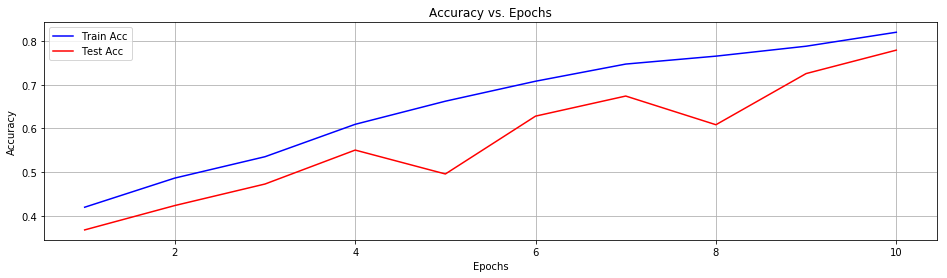

In [51]:
# with transposed dims
plt.figure(figsize= (16,4))
plt.grid()
plt.plot(range(1,11), history.acc, 'b-', label = "Train Acc")
plt.plot(range(1,11), history.test_acc,  "r-", label="Test Acc")
plt.title("Accuracy vs. Epochs")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#plt.savefig("./images/Epoch_LearningCurve.png");
plt.show();

The above learning curve shows us that transposing the matrix in order to have X, Y, Z become rows leads to bad performance. Where as the plot below shows that maintaining X, Y, Z as columns will lead to much better performance. 

----
## Conclusion


Note that the CNN model has not been optimized. It’s likely that the performance would go up with the following changes made:

1. Gridsearch hyper parameters to find optimum values.
2. Use more regularization, such as drop out.
3. Try different versions of adaptive gradient descent (i.e. Adam, nesterov)
3. Explore different architectures.

The authors of the paper stated that a 3-layer CNN performed the best on their data set (though only slightly).
A more complete analysis on this data set would include using metrics like Precision, Recall, and ROC Curves. Taking a look at a confusion matrix to see which exercises the model is confusing as identical.

But recall that the goal of this notebook is simple to demonstrates a proof of concept: that CNNs can be used to learn what the time series signitures of each physical activity looks like and classify those activities with high accuracy. And that is exactly what we have accomplished. 

-----